<a href="https://colab.research.google.com/github/uliebal/RWTH-QMB1/blob/master/1901_GSMM_cobrapy_QuantMiBi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar Quantitative Mikrobiologie
## Hands-on simulation genome scale metabolic models

The seminar is supposed to give you insight of how to work with genome scale metabolic models (GSMM) of micro-organisms. The goal is to get suggestions for genetic manipulation in order to over-produce the metabolite ???.

The seminar uses Jupyter notebooks, a new way to use and visualize code in the web. Such a notebook is composed of a sequence of cells. Cellls can be either text/comments, like this introduction, or it contains python code to be run. In this example the code is evaluated by the cloud service [Binder](https://mybinder.org/). The output for each code-cell is shown directly below it. For a overview on Jupyter notebooks read [this review](https://www.nature.com/articles/d41586-018-07196-1).

The content of the seminar is adapted from a tutorial by the project Data-Driven Design of Cell Factories and Communities (DD-DeCaF) as well as workshop information available [here](https://biosustain.github.io/cell-factory-design-course/). More information on DD-DeDaF and the original files are [here](https://github.com/DD-DeCaF/tutorials). The simulations are performed using cobrapy (see [Ebrahim et al., 2013](https://doi.org/10.1186/1752-0509-7-74)), the most widely used analysis tool for genome scale metabolic models.

The steps of this tutorial are:
 * Set-up of compute environment
   * getting *E. coli* GSMM
 * Simulation of model performance
 * Manipulating the model

Skills you learn:
* Familiarizing with Jupyter notebooks
* Retrieving genome scale model files
* Manipulating and Simulating GSMM with cobrapy   



## Set-up compute environment

Before we can analyse GSMM, we have adjust the python environment that it integrates the cobrapy toolbox and downloading the GSMM.

Some libraries that facilitate data manipulation

In [0]:
import sys
!{sys.executable} -m pip install pandas
import pandas as pd

import numpy as np

!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#import json 
#import os
#from IPython.display import HTML


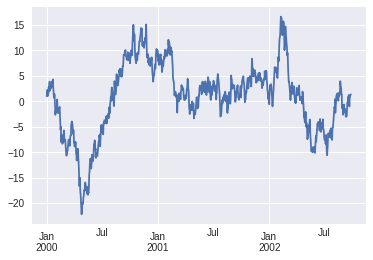

In [12]:
#ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
#ts = ts.cumsum()
ts.plot()
#!{sys.executable} -m pip install matplotlib
#import matplotlib as plt

### Git-Installation of cobrapy

In [0]:
!pip install git+https://github.com/opencobra/cobrapy;
import cobra.test
from cobra.io import read_sbml_model
from cobra.util import create_stoichiometric_matrix
from cobra.flux_analysis import production_envelope

### GSMM Download from BIGG

[BiGG](https://doi.org/10.1186/1471-2105-11-213) is a knowledgebase of Biochemically, Genetically and Genomically structured genome-scale metabolic network reconstructions. BiGG integrates several published genome-scale metabolic networks into one resource with standard nomenclature which allows components to be compared across different organisms. BiGG can be used to browse model content, visualize metabolic pathway maps, and export SBML files of the models for further analysis by external software packages. Users may follow links from BiGG to several external databases to obtain additional information on genes, proteins, reactions, metabolites and citations of interest.

In the following we download the *E. coli* model iJO1366 ([Orth et al., 2011](http://dx.doi.org/10.1038/msb.2011.65)), as well as the visualization JSON file.

In [0]:
!wget http://bigg.ucsd.edu/static/models/iJO1366.xml.gz
#!wget http://bigg.ucsd.edu/static/models/iJO1366.json

### Installation of Escher for visualization

[Escher]( https://doi.org/10.1371/journal.pcbi.1004321) is a web-based tool for building, viewing, and sharing visualizations of biological pathways. These 'pathway maps' are a great way to contextualize data about metabolism.

[Official Documentation site](https://escher.readthedocs.io/en/v1.2.0/index.html)

In [0]:
!pip install escher

import escher
import escher.urls

escher.list_available_maps() # list of available maps


## Simulation of model performance

First we have a look at general features of the model. Then we check which reaction is optimized and perform a simulation to find the optimal flux distribution to maximize the optimized reaction.

### Inspection of model features

Converting the GSMM file from the BIGG database into the 'model' data-structure that can be evaluated by the cobrapy toolbox. Just calling the variable 'model' shows some basic features of the model.

In [0]:
model = read_sbml_model('iJO1366.xml.gz')
model

Display model objective (a reverse reaction is present as well, just for mathematical reasons)

In [0]:
print(model.objective)
# model.reactions.query("BIOMASS")

generate a visualization of the stoichiometric matrix

In [0]:
stoich_matrix = create_stoichiometric_matrix(model)
plt.spy(stoich_matrix, precision=0.01, markersize=.2)

### Details to metabolite glyceraldehyde-3-phosphate

In the following we extract information of cytoplasmic glyceraldehyde-3-phosphate.
Finding metabolites that contain 'g3p_c'.

In [0]:
model.metabolites.query('g3p_c')

More specific information

In [0]:
model.metabolites.get_by_id('g3p_c')

# model.metabolites.g3p_c.reactions
## displays all reactions associated with g3p_c
## dot notation only works for 'proper' variable names, i.e. not for names starting with numbers (e.g. 10fthf_c)

Explicit list of reactions with reactants

In [0]:
for reaction in model.metabolites.g3p_c.reactions:
    print(reaction, reaction.name)

Investigating a particular reaction: GAPD

GPR shows the 'Gene-Protein-Reaction' relationship

In [0]:
model.reactions.GAPD

### Output of medium composition

Here, we display extra-cellular metabolites that can be potentially imported during the simulation. 

In [0]:
model.medium

### Simulation of optimal growth

In [0]:
# model.solver

solution = model.optimize()
print('Growth rate: %.2f' % solution.objective_value)

# E.coli core model:
# import cobra.test
# model = cobra.test.create_test_model("textbook")

Models solved using FBA can be further analyzed by using summary methods, which output printed text to give a quick representation of model behavior. Calling the summary method on the entire model displays information on the input and output behavior of the model, along with the optimized objective.

In [0]:
model.summary()
# solution.fluxes.BIOMASS_Ec_iJO1366_core_53p95M
# solution.fluxes.ATPM

In addition, the input-output behavior of individual metabolites can also be inspected using summary methods. For instance, the following commands can be used to examine the overall redox balance of the model.

In [0]:
model.metabolites.nadh_c.summary()

Or to get a sense of the main energy production and consumption reactions

In [0]:
model.metabolites.atp_c.summary()

### Visualization

Escher is a web-based tool for building, viewing, and sharing visualizations of biological pathways. These 'pathway maps' are a great way to contextualize data about metabolism.

Best help [here](https://github.com/zakandrewking/escher/blob/master/docs/notebooks/COBRApy%20and%20Escher.ipynb)

In [0]:
# Escher wants the data to be stored in a specific format, a 'dictionary'
b = escher.Builder(map_name='iJO1366.Central metabolism',
                                      reaction_data=dict(solution.fluxes),
                   # change the default colors
                   reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                   {'type': 'value', 'value': 0.1, 'color': '#cccccc', 'size': 8},
                                   {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                   {'type': 'max', 'color': '#ff0000', 'size': 40}],
                   # absolute value and no text for data
                   reaction_styles=['size', 'color', 'abs'],
                   # only show the primary metabolites
                   hide_secondary_metabolites=True)
b.display_in_notebook()

## Manipulation of the model

### Setting new objective

The objective function is determined from the objective_coefficient attribute of the objective reaction(s). Generally, a “biomass” function which describes the composition of metabolites which make up a cell is used.

The objective function can be changed by assigning Model.objective, which can be a reaction object (or just it’s name)

In [0]:
# copy model for changes to succinate
SucModel = model.copy()
# SucModel.reactions.query('suc')
# SucModel.reactions.EX_succ_e

# change objective to the synthesis of succinate
SucModel.objective = SucModel.reactions.EX_succ_e

# Because biomass is not anymore optimized, the biomass reactions will be zero for optimization to succinate because it only drains the result.
# Assuming that there is still some growth occuring, we raise the lower boundary for the growth reaction
SucModel.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').lower_bound = .2

# storing the simulation in a variable
Suc_Solution = SucModel.optimize()

#SucModel.reactions.ATPM.flux
SucModel.summary()

### Visualization of succinate optimized flux distribution

The optimization of succinate from glucose shows a theoretical conversion mechanism. Let's visualize the optmized reaction fluxes in Escher.

In [0]:
b = escher.Builder(map_name='iJO1366.Central metabolism',
                                      reaction_data=dict(Suc_Solution.fluxes),
                   # change the default colors
                   reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                   {'type': 'value', 'value': 0.1, 'color': '#cccccc', 'size': 8},
                                   {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                   {'type': 'max', 'color': '#ff0000', 'size': 40}],
                   # absolute value and no text for data
                   reaction_styles=['size', 'color', 'abs'],
                   # only show the primary metabolites
                   hide_secondary_metabolites=True)
b.display_in_notebook()

### Generating production envelopes
Production envelopes (aka phenotype phase planes) will show distinct phases of optimal growth with different use of two different substrates. For more information, see [Edwards et al.](http://dx.doi.org/10.1002/bit.10047)

In [0]:
# setting lowest growth boundary back to '0'
SucModel.reactions.get_by_id('BIOMASS_Ec_iJO1366_core_53p95M').lower_bound = 0.

prod_env = production_envelope(SucModel, reactions=SucModel.reactions.BIOMASS_Ec_iJO1366_core_53p95M, 
                               objective=SucModel.reactions.EX_succ_e)
#prod_env
prod_env.plot(kind='line', x='BIOMASS_Ec_iJO1366_core_53p95M', y='carbon_yield_maximum')

## Questions

 which reactions includes cytosolic atp? model.?.atp_c.?
 
 which metabolite is named adenosine model.metabolites.?(?,?)

which genes are necessary for PFK reaction? model.?.?.? 

Which metabolites are superfluous in the original medium composition based on the exchanged metabolites determined by the FBA?

# Further Literature

## Details to Jupyter education
The following sites provide guides to using Jupyter notebooks for educational means:
 * https://jupyter4edu.github.io/jupyter-edu-book/index.html
 * https://github.com/jperkel/example_notebook
 * https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks#mathematics-physics-chemistry-biology
 * https://github.com/binder-examples/
 * https://nbviewer.jupyter.org/
 * https://jupyter.readthedocs.io/en/latest/index.html

## more on cobrapy:
 * https://cobrapy.readthedocs.io/en/latest/getting_started.html
 * https://github.com/DD-DeCaF/tutorials
 * https://biosustain.github.io/cell-factory-design-course/

## Escher Documentation:
 * https://escher.readthedocs.io/en/v1.2.0/index.html
 * https://github.com/zakandrewking/escher/blob/master/docs/notebooks/COBRApy%20and%20Escher.ipynb
 * https://github.com/DD-DeCaF/tutorials/blob/master/escher-01.ipynb

## further material with cameo:
 * https://github.com/DD-DeCaF/tutorials
 * https://biosustain.github.io/cell-factory-design-course/
 * https://try.cameo.bio/user/M6JFMnvW35Vz/tree
 * !pip install cameo